# UNet Architecture
Taken from https://towardsdatascience.com/cityscape-segmentation-with-tensorflow-2-0-b320b6605cbf

In [1]:
import os
import time
import json
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize

import tensorflow as tf

In [2]:
print(tf.test.is_built_with_gpu_support())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

True
Num GPUs Available:  0


In [3]:
def parse_record(example_proto):
    # Create a dictionary describing the features.
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'segmentation_mask': tf.io.FixedLenFeature([], tf.string),
    }
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)


def record_to_images(record):
    features = parse_record(record)
    image = tf.io.decode_jpeg(features['image'], channels=3)
    annotation = tf.io.decode_png(features['segmentation_mask'], channels=1)
    return (image, annotation)


def read_tfrecord_dataset(filepath):
    records = tf.data.TFRecordDataset(filepath)
    return records.map(record_to_images)

In [25]:
def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    return (image, mask)

In [26]:
@tf.function
def load_image(img, mask):
    START_W = START_H = 400
    resized_image = tf.image.resize(img, (START_H, START_W))
    resized_mask = tf.image.resize(mask, (START_H, START_W))
    image, mask = normalize(resized_image, resized_mask)
    
    return image, mask


In [27]:
# Raw datasets, no resizing yet
og_train = read_tfrecord_dataset("datasets/biped_trn.tfrecord")
og_test = read_tfrecord_dataset("datasets/biped_val.tfrecord")

In [51]:
og_train.list_files()

TypeError: list_files() missing 1 required positional argument: 'file_pattern'

In [50]:
dir(og_train)

['_GeneratorState',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_map_func',
 '_maybe_initialize_trackable',
 '_name_based_attribute_restore',


In [28]:
first = None
for data in og_train:
    first = data
    break

img, mask = first
nmask = mask.numpy()

(720, 720, 1)
[  0 255]


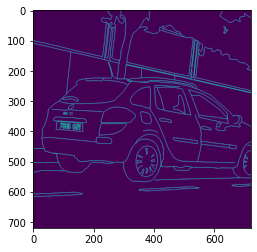

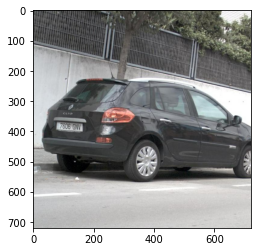

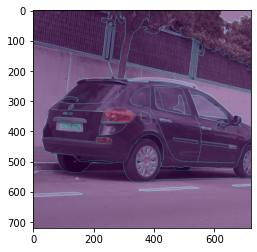

In [29]:
print(nmask.shape)
print(np.unique(nmask))
h, w, _ = nmask.shape
plt.figure(); plt.imshow(nmask.reshape(h, w))
plt.figure(); plt.imshow(img.numpy())
plt.figure(); plt.imshow(img.numpy()); plt.imshow(nmask.reshape(h, w), alpha=0.5)

In [30]:
metadata = None
with open("datasets/meta.json", "r") as rf:
    metadata = json.load(rf)

In [33]:
TRAIN_LENGTH = metadata["train_length"]
VAL_LENGTH = metadata["val_length"]
print(TRAIN_LENGTH, VAL_LENGTH)

57600 50


In [34]:
BATCH_SIZE = 8
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [65]:
dataset = tf.data.Dataset.from_tensors(test)
dir(dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_maybe_initialize_trackable',
 '_name_based_attribute_restore',
 '_name_based_restores',
 '_no_de

In [64]:
for x in dataset:
    print(x.shape)

AttributeError: '_VariantDataset' object has no attribute 'shape'

In [ ]:
dataset = tf.data.Dataset.from_tensors

In [59]:
dataset = tf.data.Dataset.from_generator(train_dataset, (tf.float32, tf.float32))

TypeError: `generator` must be callable.

In [70]:
# train = og_train.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# test = og_test.map(load_image)

In [35]:
# Create the training and testing data loaders
train = og_train.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = og_test.map(load_image)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [45]:
len(test)

TypeError: object of type 'MapDataset' has no len()

In [47]:
for step, (x,y) in enumerate(test_dataset):
    print((step, x.shape, y.shape))
    if step >= 15:
        break

(0, TensorShape([8, 400, 400, 3]), TensorShape([8, 400, 400, 1]))
(1, TensorShape([8, 400, 400, 3]), TensorShape([8, 400, 400, 1]))
(2, TensorShape([8, 400, 400, 3]), TensorShape([8, 400, 400, 1]))
(3, TensorShape([8, 400, 400, 3]), TensorShape([8, 400, 400, 1]))
(4, TensorShape([8, 400, 400, 3]), TensorShape([8, 400, 400, 1]))
(5, TensorShape([8, 400, 400, 3]), TensorShape([8, 400, 400, 1]))
(6, TensorShape([2, 400, 400, 3]), TensorShape([2, 400, 400, 1]))


In [39]:
type(train)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [42]:
dir(test)

['_GeneratorState',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_map_func',
 '_maybe_initialize_trackable',
 '_name_based_attribute_restore',


In [40]:
type(test), type(test_dataset)

(tensorflow.python.data.ops.dataset_ops.MapDataset,
 tensorflow.python.data.ops.dataset_ops.BatchDataset)

In [36]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    
    plt.show()

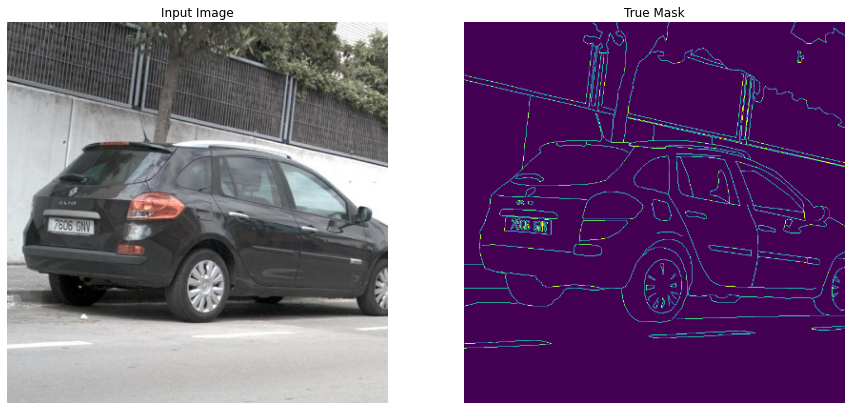

In [37]:
keep = None
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    keep = sample_image, mask
    display([sample_image, sample_mask])

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [18]:
def unet_model(output_channels):
    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]
    
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
model = unet_model(n_classes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

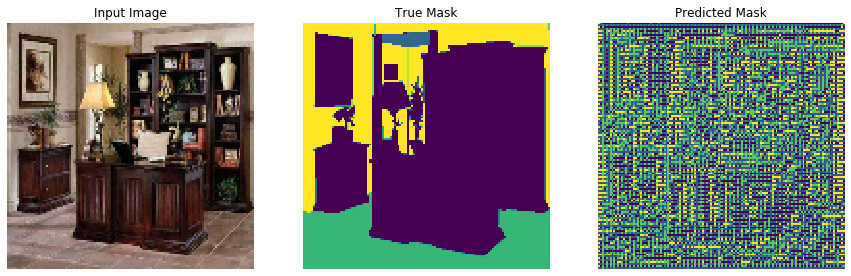

In [21]:
show_predictions()

In [22]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(test_dataset, 5)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

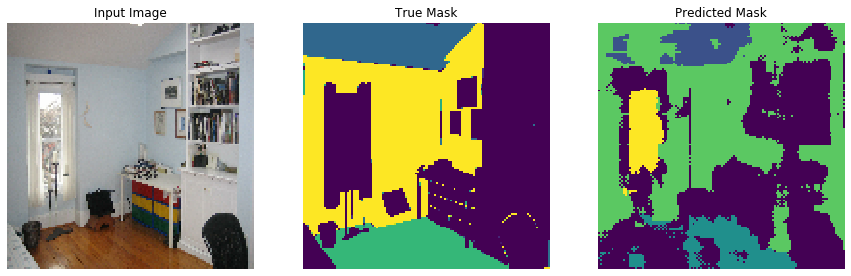

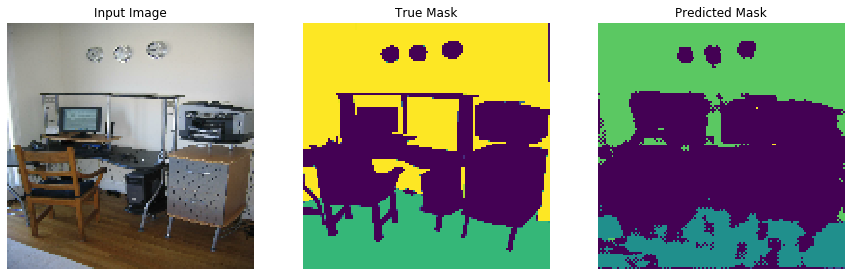

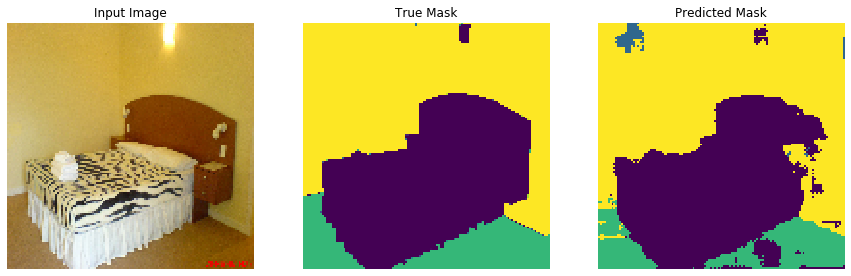

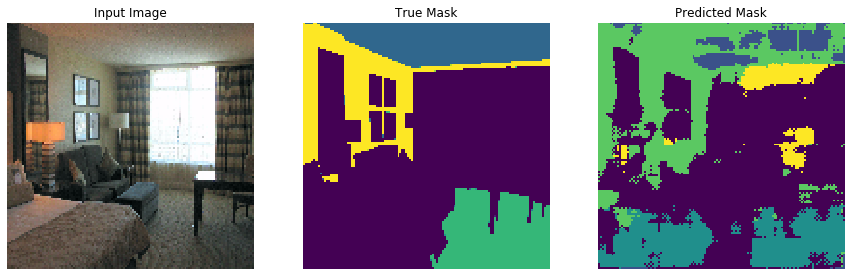

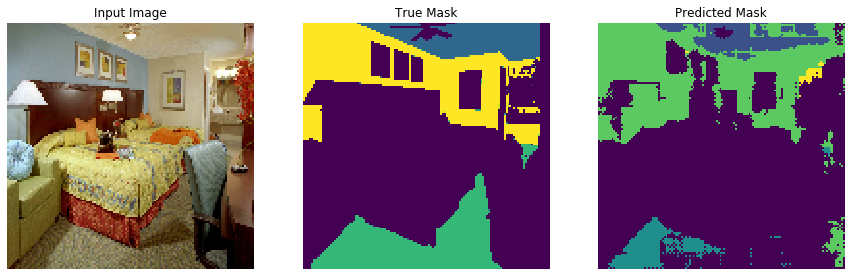


Sample Prediction after epoch 20

750/750 [==============================] - 13s 17ms/step - loss: 0.4495 - accuracy: 0.8225 - val_loss: 0.7486 - val_accuracy: 0.7222


In [23]:
EPOCHS = 20
VAL_SUBSPLITS = 1
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

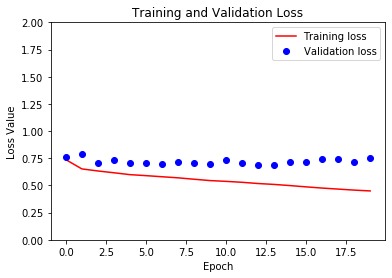

In [26]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 2])
plt.legend()
plt.show()


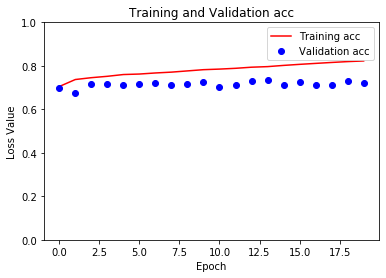

In [27]:
loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training acc')
plt.plot(epochs, val_loss, 'bo', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [29]:
model.save_weights(f"models/v4_epoch={EPOCHS}")

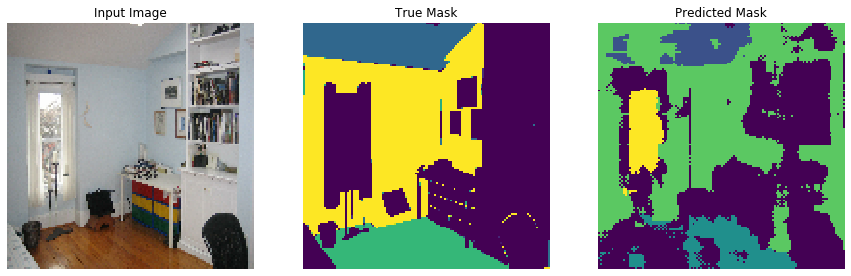

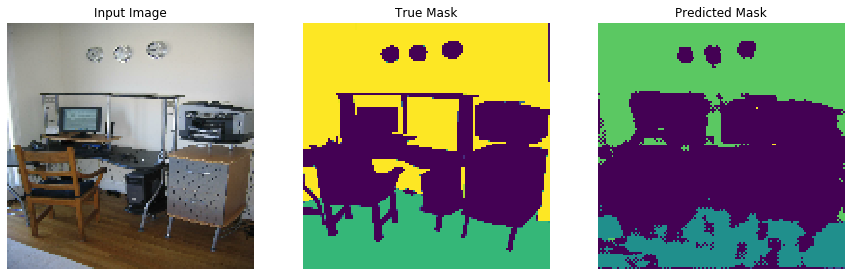

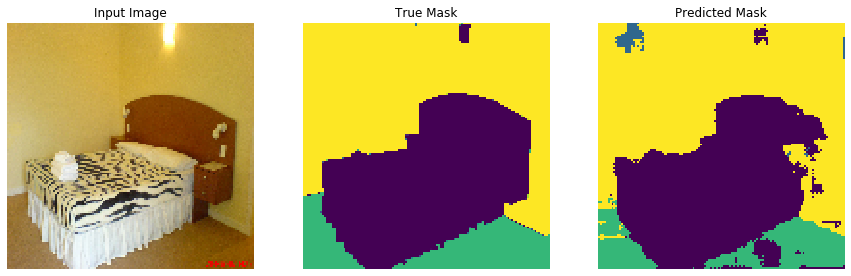

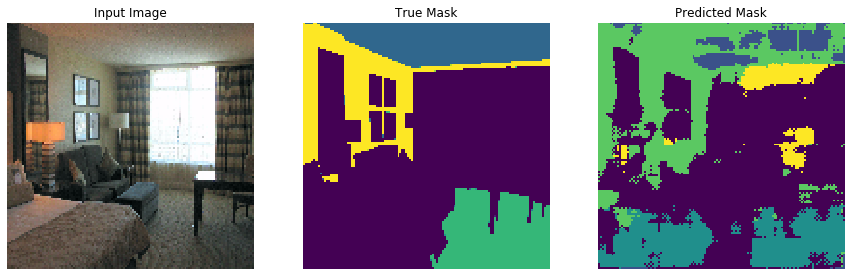

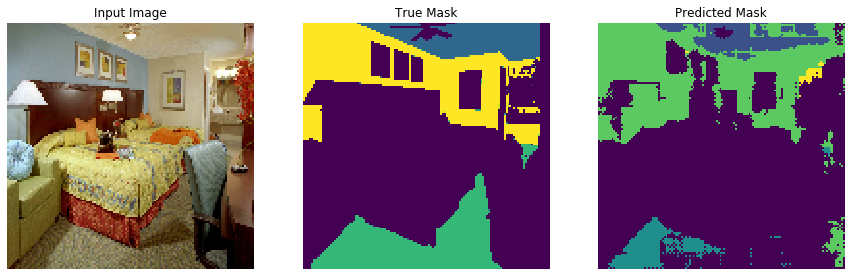

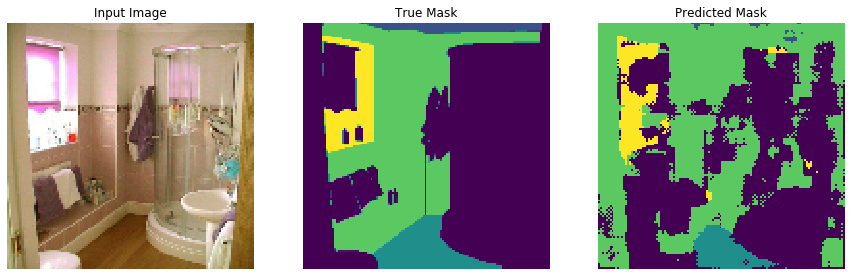

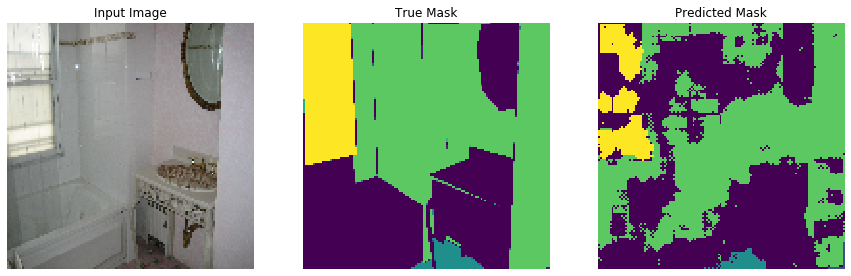

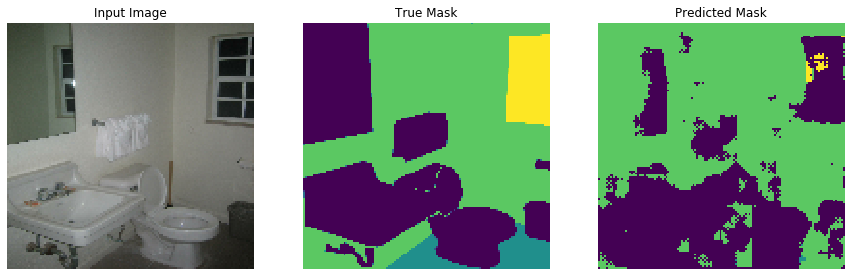

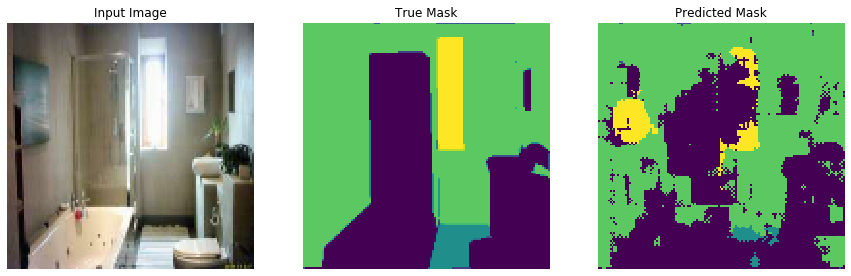

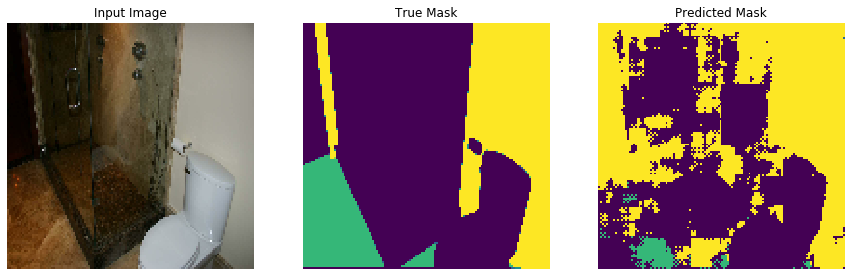

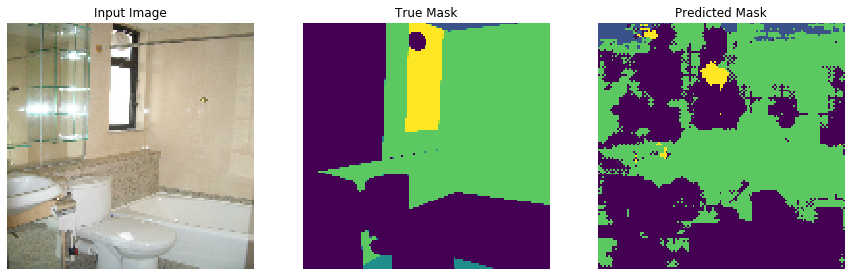

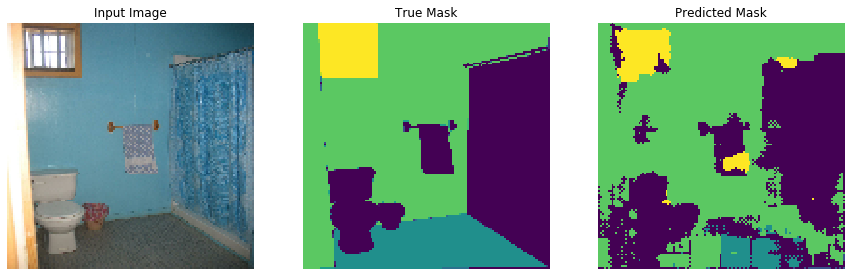

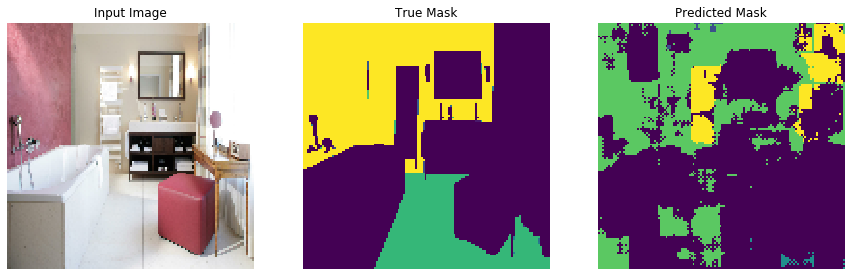

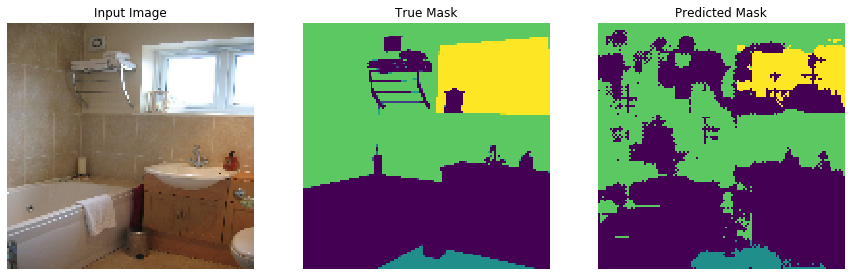

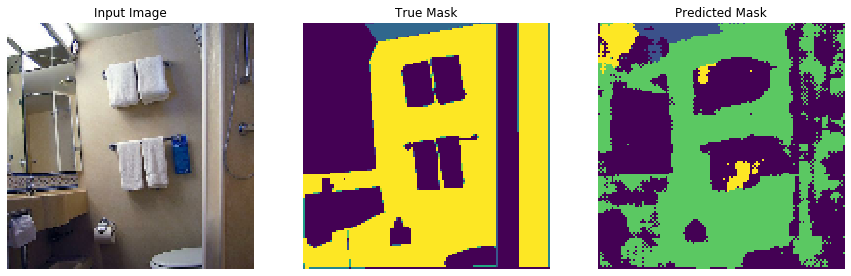

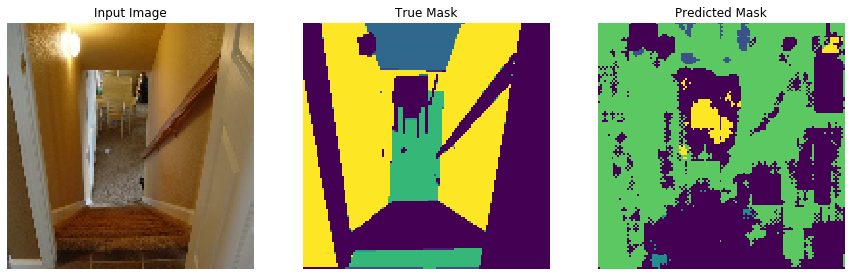

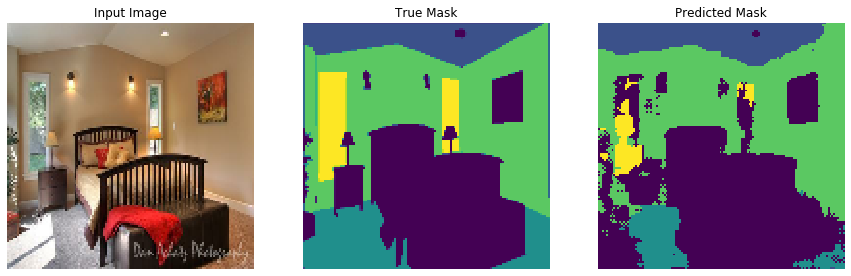

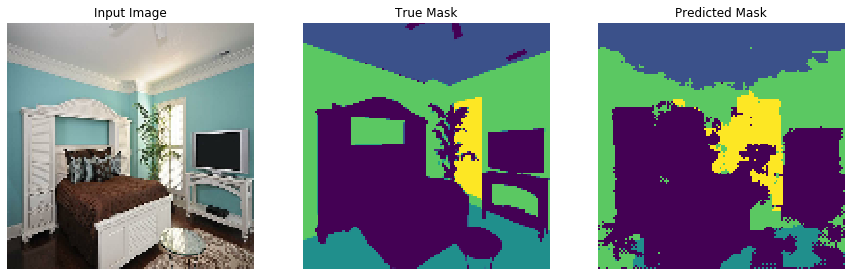

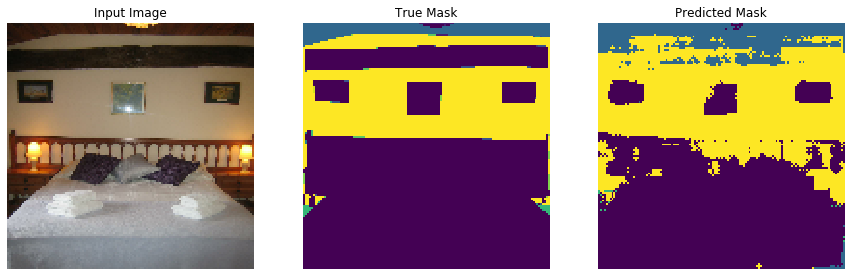

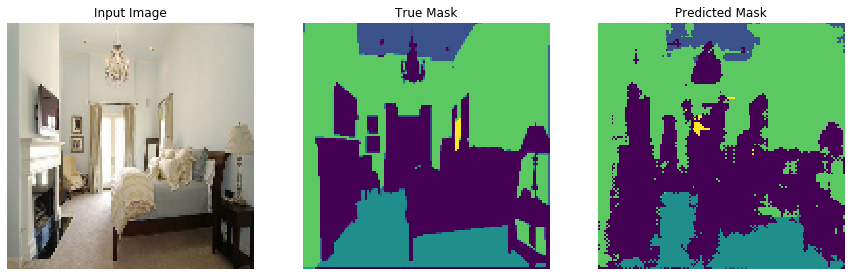

In [30]:
show_predictions(test_dataset, 20)